1. 라이브러리/데이터 불러오기

In [59]:
import numpy as np #numpy import
import pandas as pd #pandas import
from tensorflow.keras.layers import Dense,Dropout #tensorfolw.keras에서 Dense, Dropout import
from tensorflow.keras.models import Sequential #tensorfolw.keras에서 Sequential import
from tensorflow.keras.optimizers import Adam #tensorfolw.keras에서 Adam import
from tensorflow.keras.callbacks import EarlyStopping #tensorfolw.keras에서 EarlyStopping import
import matplotlib.pyplot as plt #matplotlib.pyplot import
import seaborn as sns #seaborn import
from sklearn.preprocessing import MinMaxScaler #sklearn에서 MinMaxScaler import
import os #os import
os.chdir("C:/Users/jtiger.lee/Desktop/dataset") #데이터 파일경로 지정
label_data=pd.read_csv("labeled_data.csv") #데이터 불러오기 

2. 데이터 종류 및 개수 확인

In [60]:
label_data['EQUIP_NAME'].value_counts() #기기이름별 데이터수 확인 #650톤 우진 2호기 데이터가 충분하다는 것을 알 수 있다.

650톤-우진2호기    7992
1800TON-우진       2
650톤-우진          2
Name: EQUIP_NAME, dtype: int64

In [61]:
label_data['PART_NAME'].value_counts() #제품별 데이터수 확인 #CN7,RG3 제품이 데이터가 충분하다는 것을 알 수 있다. 

CN7 W/S SIDE MLD'G RH        3371
CN7 W/S SIDE MLD'G LH        3365
RG3 MOLD'G W/SHLD, LH         628
RG3 MOLD'G W/SHLD, RH         628
SP2 CVR ROOF RACK CTR, RH       2
JX1 W/S SIDE MLD'G RH           2
Name: PART_NAME, dtype: int64

3.데이터 전처리

In [62]:
def make_input(data,machine_name,product_name): #입력데이터에서 필요없는 변수(0이 있는 변수)를 없애기 위해 make_input함수를 정의
    machine_=data["EQUIP_NAME"]==machine_name #기기명 지정 machine_name
    product_=data["PART_NAME"]==product_name #제품명 지정 product_name
    data=data[machine_&product_] #data를 기기와 제품의 합집합으로 지정
    data.drop(['_id','TimeStamp','PART_FACT_PLAN_DATE','Reason','PART_FACT_SERIAL',"PART_NAME","EQUIP_CD","EQUIP_NAME", #서술된 변수값에서 0이 있는 data 삭제 
    "Mold_Temperature_1","Mold_Temperature_2","Mold_Temperature_5","Mold_Temperature_6","Mold_Temperature_7","Mold_Temperature_8",
    "Mold_Temperature_9","Mold_Temperature_10","Mold_Temperature_11","Mold_Temperature_12"],axis=1,inplace=True)
    return data 

In [63]:
#사출기 종류
machine_name="650톤-우진2호기"
#데이터 제품 종류
product_name=["CN7 W/S SIDE MLD'G RH", "CN7 W/S SIDE MLD'G LH", "RG3 MOLD'G W/SHLD, LH","RG3 MOLD'G W/SHLD, RH"]

#"650톤-우진2호기"의 "CN7 W/S SIDE MLD'G RH"데이터만 변수를 제거하여 가져옴
cn7rh=make_input(label_data,machine_name,product_name[0])
#"650톤-우진2호기"의 "CN7 W/S SIDE MLD'G LH"데이터만 변수를 제거하여 가져옴
cn7lh=make_input(label_data,machine_name,product_name[1])
#"650톤-우진2호기"의 "RG3 MOLD'G W/SHLD, LH"데이터만 변수를 제거하여 가져옴
rg3lh=make_input(label_data,machine_name,product_name[2])
#"650톤-우진2호기"의 "RG3 MOLD'G W/SHLD, RH"데이터만 변수를 제거하여 가져옴
rg3rh=make_input(label_data,machine_name,product_name[3])

#동일한 제품의 LH와 RH는 합쳐줌
cn7=pd.concat([cn7lh,cn7rh],ignore_index=True) # cn7lh,cn7rh 데이터 합침
rg3=pd.concat([rg3lh,rg3rh],ignore_index=True) # rg3lh,rg3rh 데이터 합침

#rg3에 Plasticizing_Position 변수값이 모두 0이므로 삭제
rg3.drop(['Plasticizing_Position'],axis=1,inplace=True)
#cn7에 Barrel_Temperature_7,Switch_Over_Position 변수값이 모두 0이므로 삭제
cn7.drop(['Barrel_Temperature_7','Switch_Over_Position'],axis=1,inplace=True)



C:\Users\jtiger.lee\AppData\Local\Temp\ipykernel_68824\2973197375.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['_id','TimeStamp','PART_FACT_PLAN_DATE','Reason','PART_FACT_SERIAL',"PART_NAME","EQUIP_CD","EQUIP_NAME",
C:\Users\jtiger.lee\AppData\Local\Temp\ipykernel_68824\2973197375.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['_id','TimeStamp','PART_FACT_PLAN_DATE','Reason','PART_FACT_SERIAL',"PART_NAME","EQUIP_CD","EQUIP_NAME",
C:\Users\jtiger.lee\AppData\Local\Temp\ipykernel_68824\2973197375.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

4.데이터 특성 파악

In [64]:
#cn7제품을 describe함수를 써서 통계량 파악하기
cn7['PassOrFail']=cn7['PassOrFail'].replace('Y',0).replace('N',1) #Y(양품)는 0으로 N(불량)은 1로 바꾸기
cn7.describe() #ch7제품 통계량파악

,PassOrFail,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,...,Average_Back_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
count,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,...,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000
mean,0.005790,9.580064,4.448425,16.820433,59.549314,7.113639,653.440859,68.381941,644.899046,55.523085,...,59.347209,275.965024,275.134961,274.858091,270.285823,254.924346,229.971512,66.663094,22.074228,23.473619
std,0.075876,0.180526,0.140286,0.288946,0.372267,0.075843,0.115004,0.648307,42.170577,1.005340,...,3.530820,2.302366,1.887356,1.854329,2.018081,1.134566,0.428762,2.433782,1.171389,1.370780
min,0.000000,9.360000,3.350000,16.469999,58.840000,6.070000,653.390015,59.759998,69.639999,38.500000,...,13.300000,244.699997,249.000000,249.600006,244.399994,239.699997,224.600006,38.500000,19.100000,20.600000
25%,0.000000,9.530000,4.420000,16.629999,59.480000,7.120000,653.429993,68.320000,647.989990,55.099998,...,59.400002,275.799988,275.000000,274.799988,269.700012,254.800003,229.800003,65.599998,21.200001,22.600000
50%,0.000000,9.570000,4.450000,16.820000,59.520000,7.120000,653.429993,68.360001,647.989990,55.400002,...,59.500000,276.100006,275.299988,275.000000,270.399994,255.000000,230.000000,67.000000,21.900000,23.299999
75%,0.000000,9.600000,4.480000,16.910000,59.540001,7.120000,653.440002,68.510002,647.989990,55.900002,...,59.700001,276.399994,275.500000,275.200012,271.100006,255.199997,230.100006,67.800003,22.799999,24.200001
max,1.000000,13.390000,8.270000,21.100000,64.349998,7.180000,655.000000,68.860001,647.989990,64.800003,...,90.800003,277.899994,276.500000,276.000000,272.399994,256.299988,230.699997,70.599998,25.299999,27.799999


In [136]:
cn7.to_csv("cn7.csv",index=False) #cn7 파일내보내기

<AxesSubplot: >

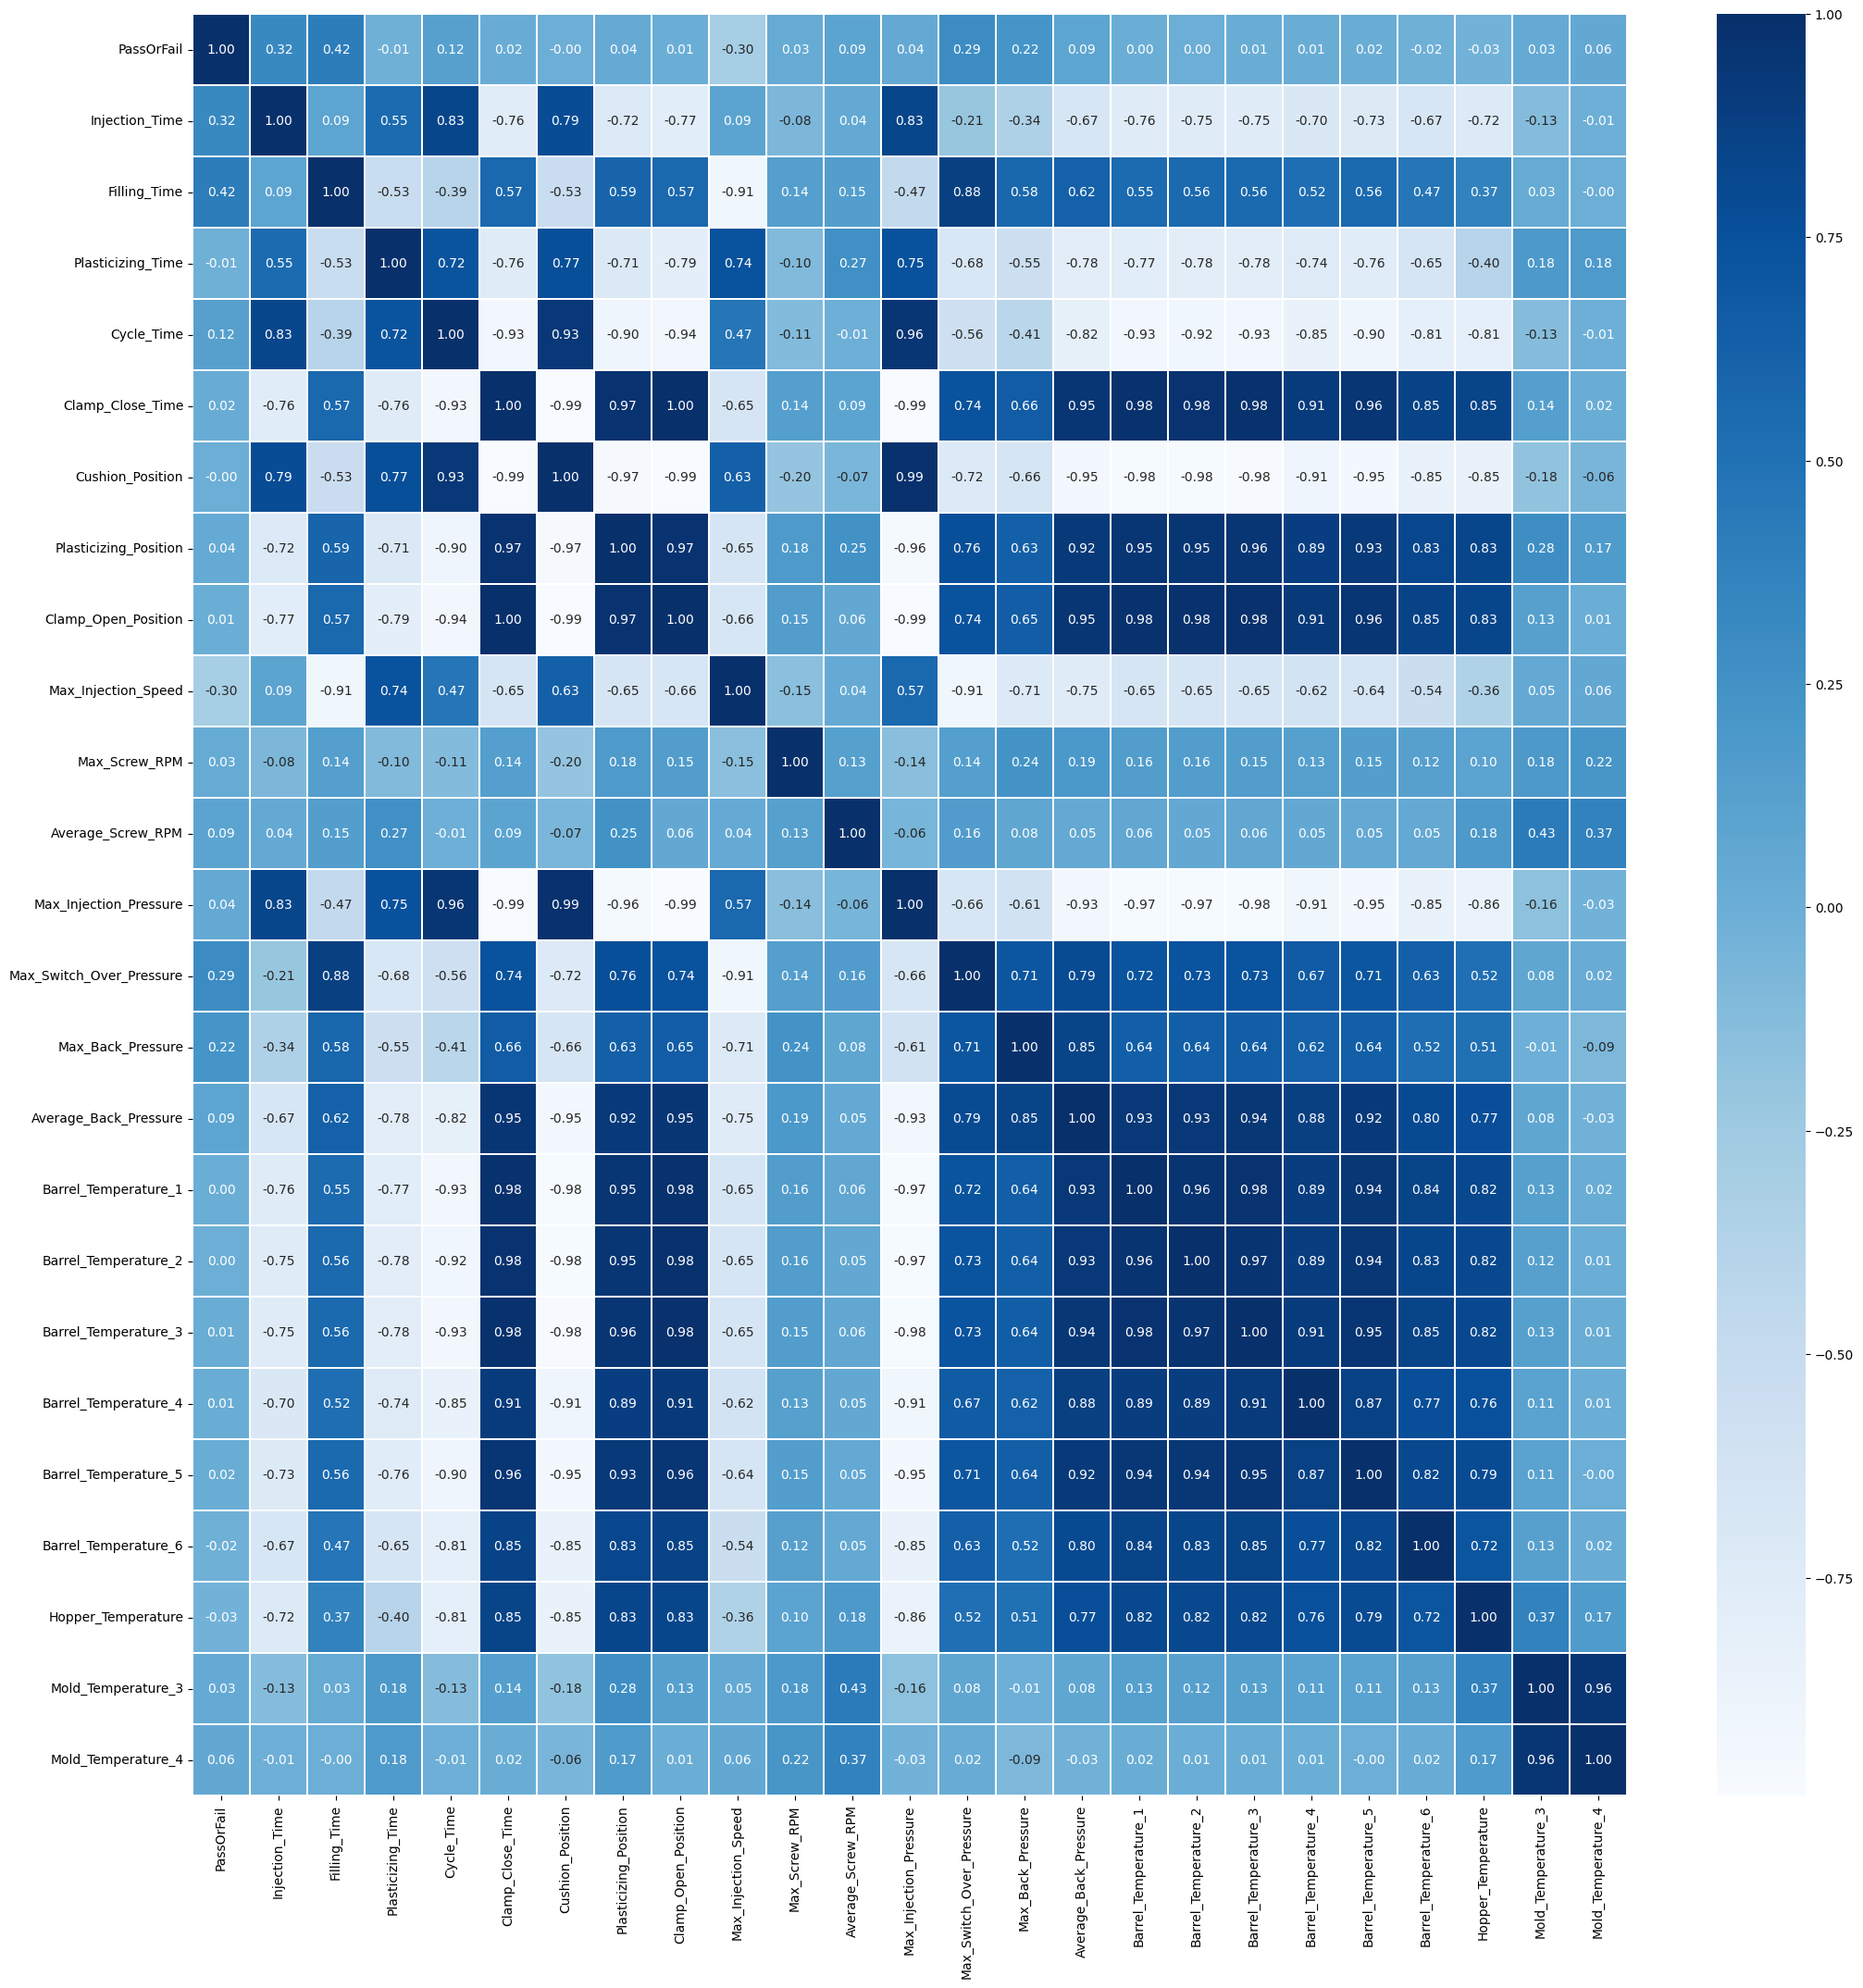

In [65]:
#cn7제품을 corr함수를 통한 변수 간 상관관계 파악하기
#피어슨 상관계수로 절대값이 1에 가까울 수록 선형관계에 있다. 
plt.subplots(figsize=(25,25)) #ch7제품 통계량파악
sns.heatmap(data=cn7.corr(),linewidths=0.1,annot=True,fmt='.2f',cmap='Blues') ##seaborn을 사용하여 ch7 변수간 상관관계 시각화

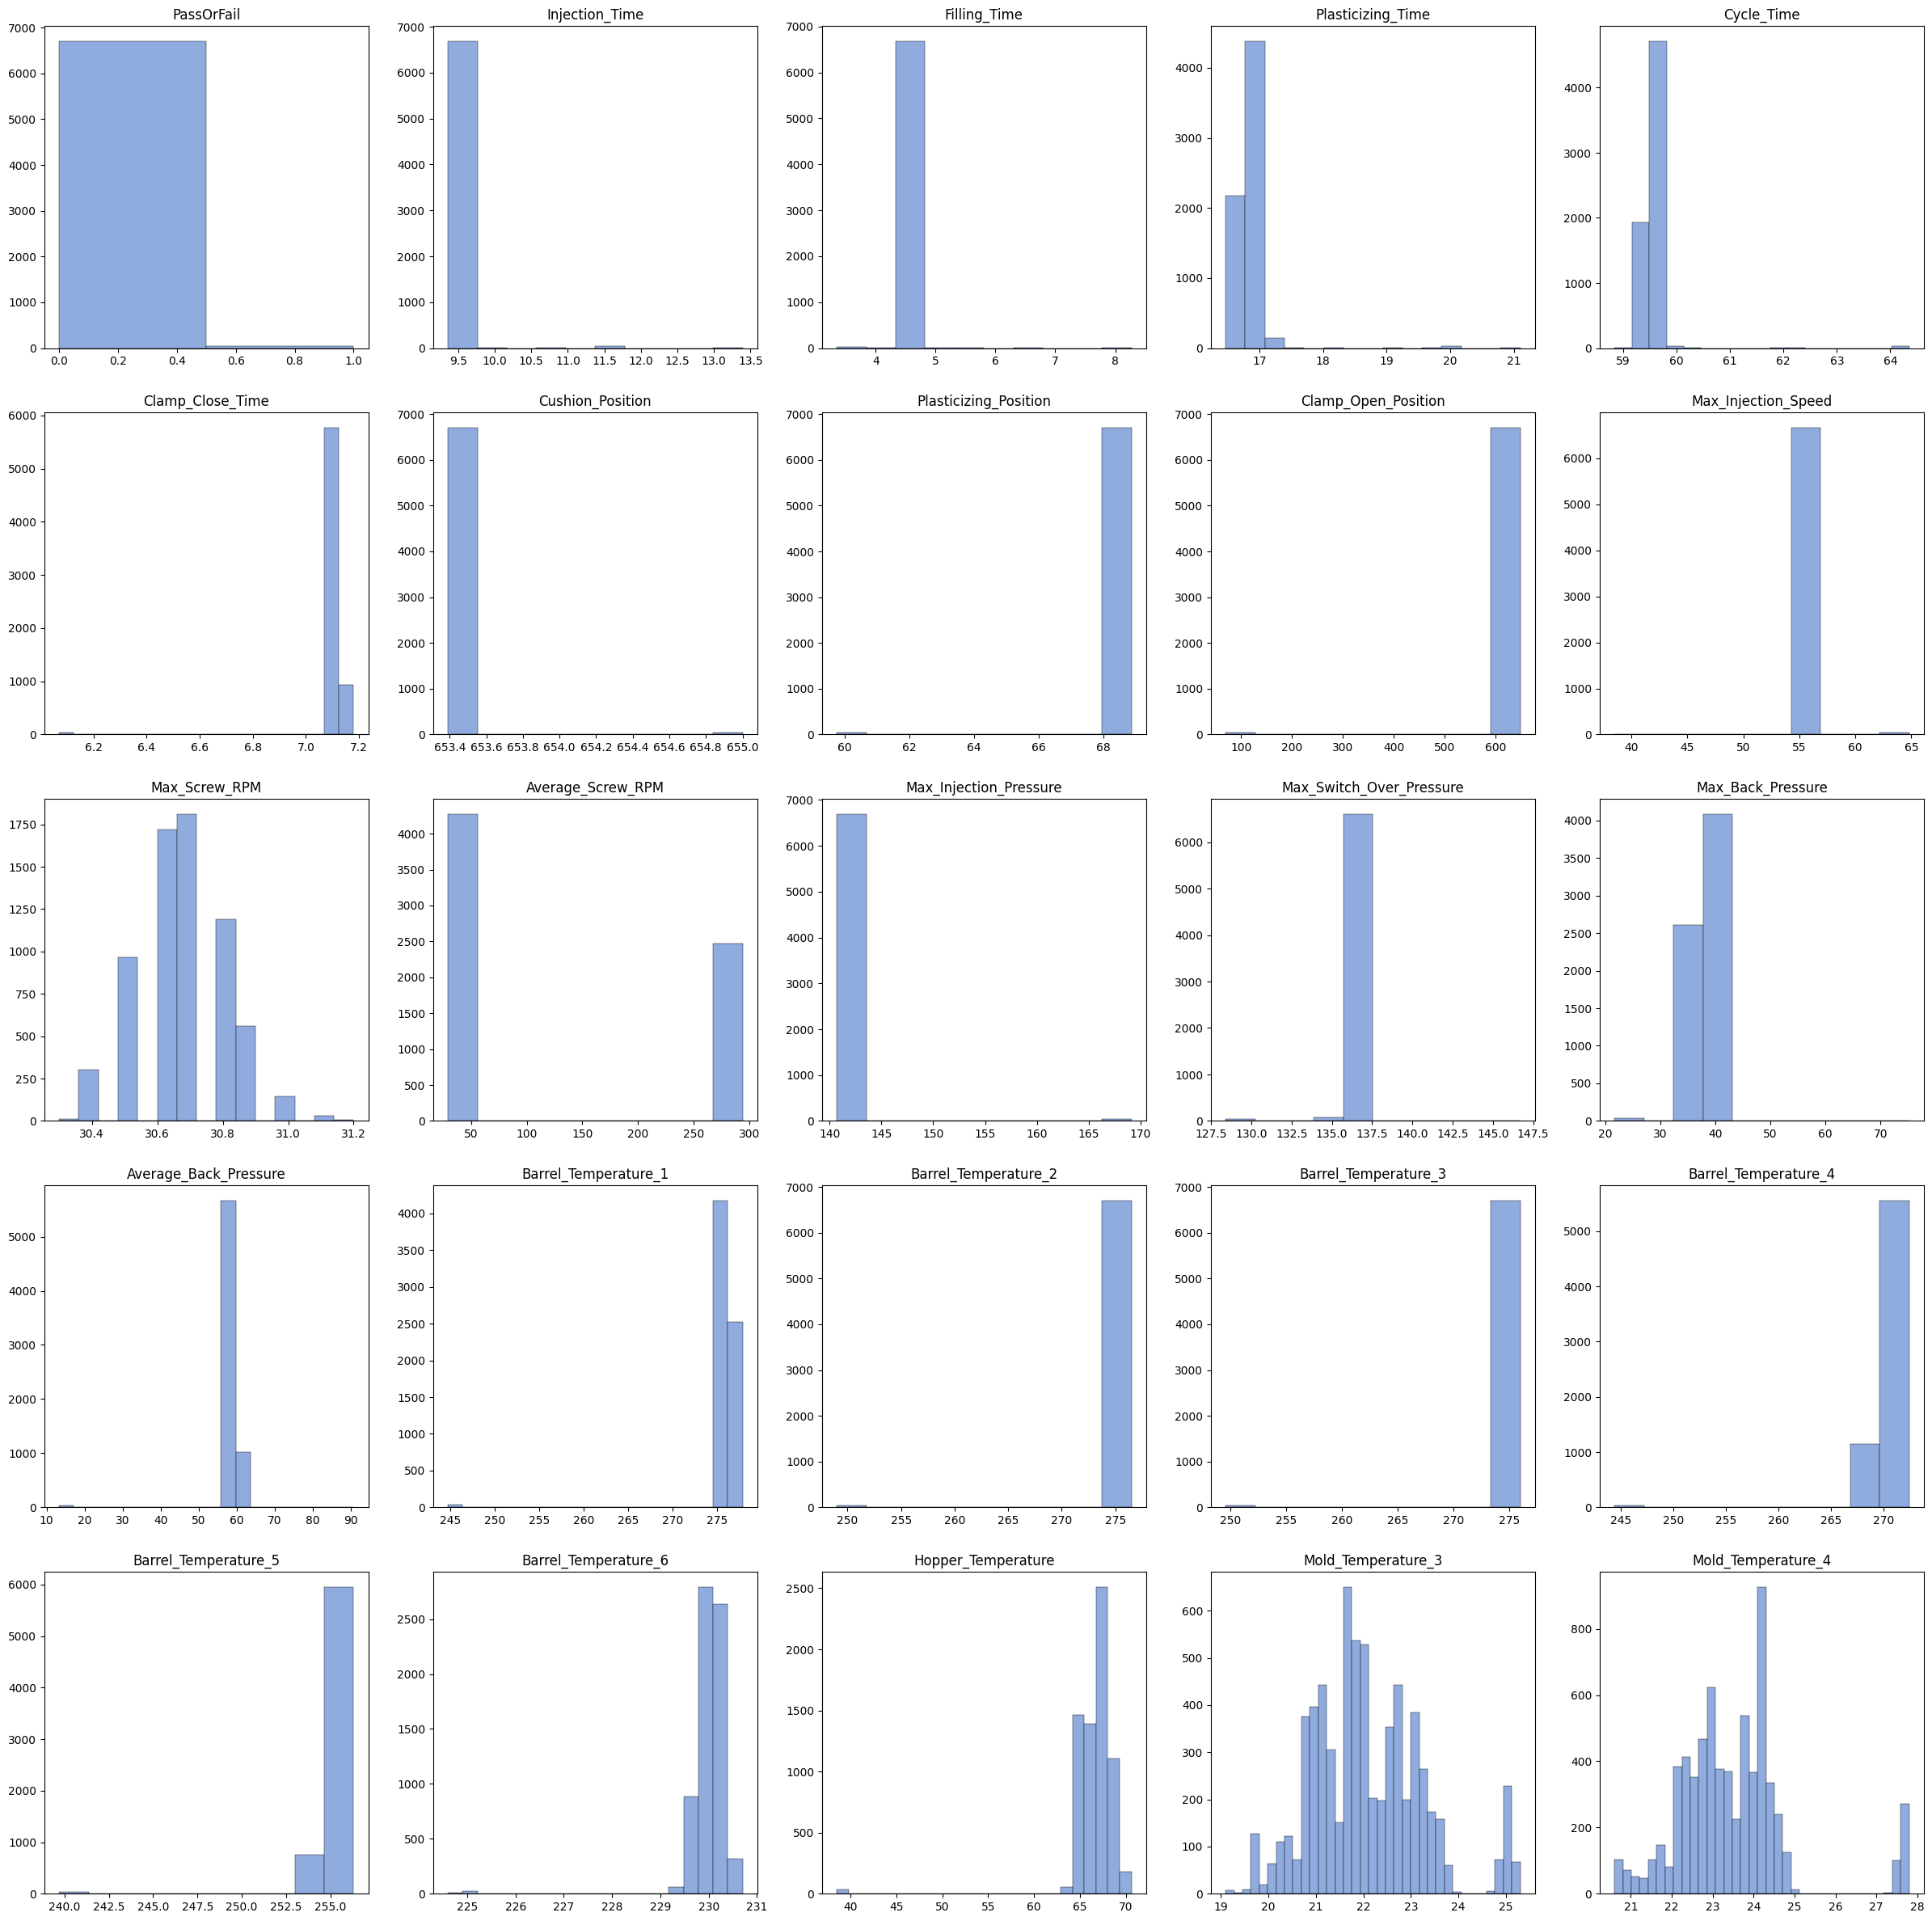

In [66]:
#cn7제품의 histogram을 통한 변수별 데이터 파악
plt.figure(figsize=(30,30))
#각 변수의 막대그래프 개수를  bin에 list로 설정
bin=[2,10,10,15,17,20,10,10,10,10,15,10,10,10,10,20,20,10,10,10,10,20,25,35,35]

for index,value in enumerate(cn7): #각 변수별 구간을 bin으로 지정하여 시각화 
    sub=plt.subplot(5,5,index+1)
    sub.hist(cn7[value],bins=bin[index],facecolor=(144/255,171/255,221/255),linewidth=.3,edgecolor='black')
    plt.title(value)

5.Train/Test 데이터 분리

In [90]:
#cn7의 양품과 불량 개수 확인
cn7['PassOrFail'].value_counts()

0    6697
1      39
Name: PassOrFail, dtype: int64

In [68]:
#train 데이터 양품과 불량품 분리
cn7_Y=cn7[cn7['PassOrFail']==0] #양품개수분리
print('CN7의 양품개수:',len(cn7_Y)) #양품개수 print
cn7_N=cn7[cn7['PassOrFail']==1] #불량품개수분리
print('CN7의 불량품개수:',len(cn7_N)) #불량품개수 print

#test 데이터 양품과 불량품 분리 
cn7_Y.drop(['PassOrFail'],axis=1,inplace=True) #양품데이터에서 양품/불량품 항목 삭제
cn7_N.drop(['PassOrFail'],axis=1,inplace=True) #불량품데이터에서 양품/불량품 항목 삭제

CN7의 양품개수: 6697
CN7의 불량품개수: 39


C:\Users\jtiger.lee\AppData\Local\Temp\ipykernel_68824\2200599738.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cn7_Y.drop(['PassOrFail'],axis=1,inplace=True)
C:\Users\jtiger.lee\AppData\Local\Temp\ipykernel_68824\2200599738.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cn7_N.drop(['PassOrFail'],axis=1,inplace=True)


In [69]:
#데이터 정규화 
scaler=MinMaxScaler() #모든 특성이 정확하게 0과 1 사이에 위치하도록 데이터를 변경함
cn7_Y=scaler.fit_transform(cn7_Y) #양품을 0~1로 정규화
cn7_N=scaler.fit_transform(cn7_N) #불량품을 0~1로 정규화
#train:test=6:4분리
cn7_train_Y=cn7_Y[:4000]
cn7_test_Y=cn7_Y[4000:]
cn7_test_N=cn7_N
print('CN7의 양품 학습 데이터 개수:',len(cn7_train_Y)) #cn7 양품 학습 데이터 개수 print
print('CN7의 양품 평가 데이터 개수:',len(cn7_test_Y)) #cn7 양품 평가 데이터 개수 print
print('CN7의 불량품 평가 데이터 개수:',len(cn7_test_N)) #cn7 불량품 평가 데이터 개수 print

CN7의 양품 학습 데이터 개수: 4000
CN7의 양품 평가 데이터 개수: 2697
CN7의 불량품 평가 데이터 개수: 39


In [109]:
#Sequential모델로 데이터 잡음 제거
# dropout:입력층과 출력층 사이의 은닉층(hidden layer)이나 입력층의 일부 뉴런(유닛, 노드)을 무작위로 생략하는 것이며, 신경망 모델이 더 견고하고 안정적으로 학습할 수 있도록 도와주는 역할
#인코더
dropout_encoder=Sequential([Dropout(0.3),Dense(15,activation="relu"),#첫 번째 은닉층
Dense(5,activation="relu")]) #두 번째 은닉층 #인코더에서 입력데이터를 저차원으로 축소한다. 
#디코더
dropout_decoder=Sequential([Dense(15,activation="relu",input_shape=[5]), #세 번째 은닉층
Dense(cn7_train_Y.shape[1],activation="relu")]) #출력
dropout_AE=Sequential([dropout_encoder,dropout_decoder]) #오토인코더 모델생성

In [110]:
#손실함수, 옵티마이저 정의 및 모델 컴파일,훈련
#손실함수 => MSE , 옵티마이저 => ADAM, 훈련평가는 => 정확도 평가
dropout_AE.compile(loss='mse',optimizer=Adam(learning_rate=0.01),metrics='accuracy')
#배치크기 30, 에포크 30, 검증데이터는 학습데이터의 20%
#얼리스탑핑을 사용하여 손실값이 향상되지 않을 때 훈련중지(patience를 주어 에포크 개선이 없을 때 빨리끝낸다.)
history = dropout_AE.fit(cn7_train_Y,cn7_train_Y,batch_size=30,epochs=30,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7,mode='min')])

Epoch 1/30
107/107 [==============================] - 1s 3ms/step - loss: 0.0653 - accuracy: 0.2716 - val_loss: 0.0145 - val_accuracy: 0.7937
Epoch 2/30
107/107 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 0.7297 - val_loss: 0.0092 - val_accuracy: 0.7800
Epoch 3/30
107/107 [==============================] - 0s 2ms/step - loss: 0.0090 - accuracy: 0.8056 - val_loss: 0.0096 - val_accuracy: 0.6963
Epoch 4/30
107/107 [==============================] - 0s 2ms/step - loss: 0.0084 - accuracy: 0.8266 - val_loss: 0.0085 - val_accuracy: 0.8975
Epoch 5/30
107/107 [==============================] - 0s 2ms/step - loss: 0.0080 - accuracy: 0.8534 - val_loss: 0.0051 - val_accuracy: 0.9688
Epoch 6/30
107/107 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 0.8612 - val_loss: 0.0050 - val_accuracy: 0.6662
Epoch 7/30
107/107 [==============================] - 0s 2ms/step - loss: 0.0080 - accuracy: 0.8316 - val_loss: 0.0065 - val_accuracy: 0.9688
Epoch 

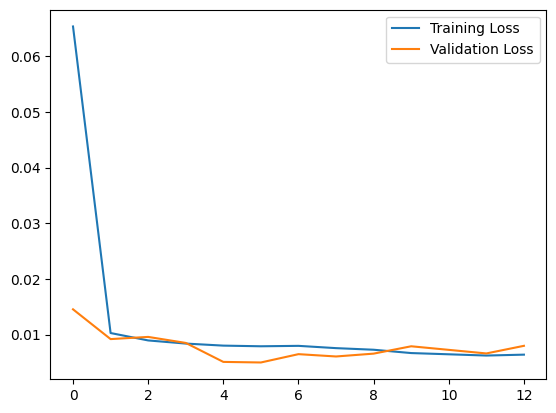

In [111]:
#그래프로 손실률 시각화
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()

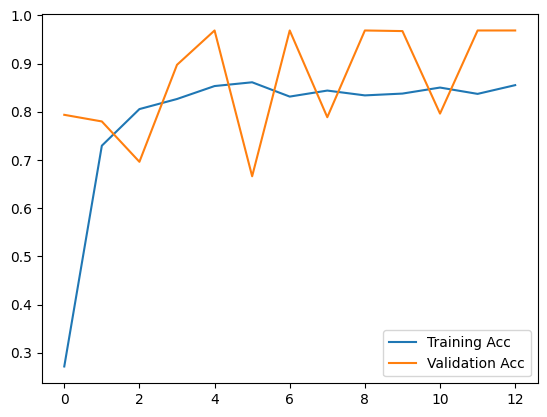

In [112]:
#그래프로 에포크정확도 시각화 
plt.plot(history.history['accuracy'],label='Training Acc')
plt.plot(history.history['val_accuracy'],label='Validation Acc')
plt.legend()
plt.show()

In [113]:
#양품 및 불량 구분을 위한 임계치 설정 : 5시그마로 사용
#학습데이터의 예측값
cn7_train_pred=dropout_AE.predict(cn7_train_Y)
#학습데이터의 복원 오차 (예측값-실제값)
cn7_train_loss=np.mean(np.square(cn7_train_pred-cn7_train_Y),axis=1)
#임계치
threshold=np.mean(cn7_train_loss)+5*np.std(cn7_train_loss)

print("복원 오류 임계치:",threshold)


125/125 [==============================] - 0s 991us/step
복원 오류 임계치: 0.038538660457994936


85/85 [==============================] - 0s 999us/step


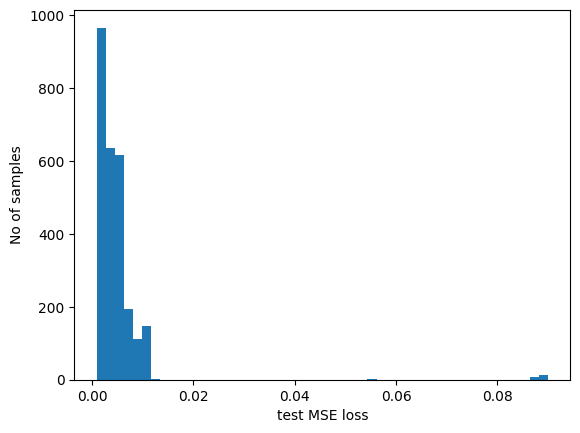

불량 개수: 22


In [114]:
#데이터 예측과 복원 오차 확인
#예측값
cn7_predict_Y=dropout_AE.predict(cn7_test_Y)
#양품 평가 데이터의 복원 오차 (예측값-실제값)
cn7_test_Y_mse=np.mean(np.square(cn7_predict_Y-cn7_test_Y),axis=1)
#시각화
plt.hist(cn7_test_Y_mse,bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.show()

#불량으로 판단한 데이터 확인
cn7_test_Y_anomalies=cn7_test_Y_mse>threshold
print("불량 개수:",np.sum(cn7_test_Y_anomalies))


2/2 [==============================] - 0s 3ms/step


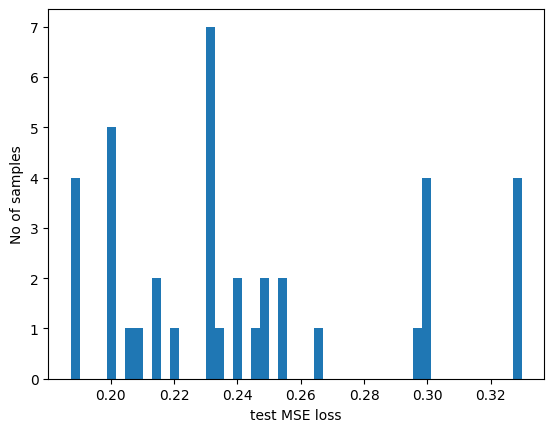

불량 개수: 39


In [115]:
#불량 평가 데이터
#예측값
cn7_predict_N=dropout_AE.predict(cn7_test_N)
#불량 평가 데이터의 복원 오차 (예측 값-실제 값)
cn7_test_N_mse=np.mean(np.square(cn7_predict_N-cn7_test_N),axis=1)
#시각화
plt.hist(cn7_test_N_mse,bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.show()

#불량으로 판단한 데이터 확인
cn7_test_N_anomalies=cn7_test_N_mse>threshold
print("불량 개수:",np.sum(cn7_test_N_anomalies))

6. 결과 분석 및 해석

In [116]:
#오차행렬로 모델평가
cn7_true=np.concatenate([np.zeros(len(cn7_test_Y_anomalies)),np.ones(len(cn7_test_N_anomalies))]) #평가데이터의 실제값
cn7_prediction=np.concatenate([cn7_test_Y_anomalies,cn7_test_N_anomalies]) #평가데이터의 예측값

from sklearn.metrics import confusion_matrix #sklearn에서 오차행렬 import
confusion_matrix(cn7_true,cn7_prediction) #cn7_true,cn7_prediction를 오차행렬로 정리

array([[2675,   22],
       [   0,   39]], dtype=int64)

In [117]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score #sklearn에서 오차행렬 주요 평가 지수 import
print("정확도:",accuracy_score(cn7_true,cn7_prediction))  #정확도 print
print("정밀도:",precision_score(cn7_true,cn7_prediction)) #정밀도,재현율 print
print("민감도:",recall_score(cn7_true,cn7_prediction)) #민감도 print
print("f1:",f1_score(cn7_true,cn7_prediction)) #F1-score print

정확도: 0.9919590643274854
정밀도: 0.639344262295082
민감도: 1.0
f1: 0.78
